In [35]:
import bagpipes as pipes
import numpy as np
import pandas as pd

Modifico il file con la risposta dei filtri in modo tale da avere 15 files per i 15 filtri, con due colonne riportanti lunghezze d'onda in Angstrom e trasmissione.

In [36]:
with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300', 'r') as f:
  lines = f.readlines()            #file con curve di trasmissione di tutti i filtri
f.close()

with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300.info', 'r') as f:
  markers = f.readlines()         #file con info sui filtri, le cui stringhe separano i dati nel precedente, lo uso per separare le curve dei singoli filtri 
f.close()

off = []
for mark in markers:       
 for i,line in enumerate(lines):
   if (line in mark):
    off.append(int(i))
off.append(len(lines))

filter_list = []

for i in range(len(off)-1):      #separo i filtri
   filename = 'filters/filt_%d.txt' % (i+1)
   with open(filename, 'w') as f:
    for line in lines[off[i]+1:off[i+1]]:
      f.write(line)
    filter_list.append(filename)
   f.close()

#print(lines[off[0]+1:off[1]])


In [37]:
for filename in filter_list:
  df = pd.read_csv(filename, sep="     ", names=['Number', 'Lambda', 'Transmittance'], engine='python')
  #print(df)
  df = df.drop(columns = 'Number')
  print(df.head(10))
  df.to_csv(filename, sep = ' ', header = False, index = False)

   Lambda  Transmittance
0  9540.0       0.025401
1  9550.0       0.028100
2  9560.0       0.033062
3  9570.0       0.037622
4  9580.0       0.043422
5  9590.0       0.050846
6  9600.0       0.059126
7  9610.0       0.068251
8  9620.0       0.079256
9  9630.0       0.092076
    Lambda  Transmittance
0  11430.0       0.009115
1  11440.0       0.009073
2  11450.0       0.010162
3  11460.0       0.011654
4  11470.0       0.013607
5  11480.0       0.015592
6  11490.0       0.018780
7  11500.0       0.022590
8  11510.0       0.026625
9  11520.0       0.031378
    Lambda  Transmittance
0  14610.0       0.008064
1  14620.0       0.008779
2  14630.0       0.008666
3  14640.0       0.009143
4  14650.0       0.009388
5  14660.0       0.010778
6  14670.0       0.011716
7  14680.0       0.012515
8  14690.0       0.012943
9  14700.0       0.014259
    Lambda  Transmittance
0  19340.0       0.004569
1  19350.0       0.007885
2  19360.0       0.006529
3  19370.0       0.006987
4  19380.0       0.0071

Costruisco un modello all'interno di una funzione, facendo predizioni delle magnitudini nelle bande di interesse

In [38]:
def mag_AB(age, tau, Av, massstar, filter_list):
  exp = {}                          # Tau model star formation history component
  exp["age"] = age                  # Gyr
  exp["tau"] = tau                  # Gyr
  exp["massformed"] = massstar      # log_10(M*/M_solar)
  exp["metallicity"] = 1.           # Z/Z_oldsolar

  dust = {}                         # Dust component
  dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
  dust["Av"] = Av                   # magnitudes

  model_components = {}                   # The model components dictionary
  model_components["redshift"] = 1.0      # Observed redshift  
  model_components["exponential"] = exp   
  model_components["dust"] = dust

  model = pipes.model_galaxy(model_components, filt_list=filter_list, phot_units= 'mujy')
  fluxes = model.photometry
  #fig = model.plot()
  #fig = model.sfh.plot()
  mags = [-2.5*np.log10(flux/(3631*10**6)) for flux in fluxes]
  return mags

In [39]:

print('predicted AB magnitudes',mag_AB(3, 0.75, 0.2, 9, filter_list))


predicted AB magnitudes [26.49245499363532, 26.091379047772012, 25.702559251013017, 25.395141787960736, 29.01421359208004, 28.733586289388132, 28.95469033059506, 28.343406876216225, 27.49746799871721, 26.769490468306824, 29.066524349210013, 25.143866278736738, 25.44560641285142, 25.839731746893623, 26.215386239280832]


Leggo il catalogo da file

In [40]:
c_list =pd.Index(['id', 'ra', 'dec', 'Ks_tot', 'eKs_tot', 'Ks', 'eKs', 'H', 'eH', 'J', 'eJ','Y', 'eY', 'zp','ezp','ip','eip','rp','erp', 'V','eV','gp','egp','B','eB','u','eu','ch1','ech1','ch2','ech2','ch3','ech3','ch4','ech4'])
df = pd.read_csv('COSMOS_photometry/UVISTA4.1_trimmed.cat', sep=' ', header=None, skipinitialspace= True, skiprows= 2, engine='python')
df.columns = c_list
print(df.head(10))

   id         ra       dec      Ks_tot   eKs_tot          Ks       eKs  \
0   3  150.40550  1.606911   83.582300  1.231353   41.648010  0.331073   
1   4  150.39050  1.604330   12.480370  0.560622    8.833714  0.254183   
2   5  150.40334  1.606078   80.197670  0.917076   44.662380  0.337045   
3  11  150.41180  1.610758  610.410900  2.202923  259.391400  0.639004   
4  13  150.37770  1.608251  126.049200  1.280248   63.677620  0.373997   
5  15  150.41135  1.605257    1.989051  0.235894    2.146189  0.235148   
6  16  150.41338  1.605285    2.310419  0.244106    2.096174  0.235148   
7  18  150.38197  1.606297    6.165348  0.644230    4.141958  0.241120   
8  21  150.40453  1.606700    2.818413  0.333313    2.321243  0.235894   
9  22  150.38472  1.608538   31.433270  0.703577   20.444780  0.283670   

            H        eH           J  ...         u        eu         ch1  \
0   35.248260  0.253064   25.341820  ...  1.824820  0.093686   32.894920   
1    6.042175  0.211260    4.2345

Carico i dati della prima galassia (id 3)

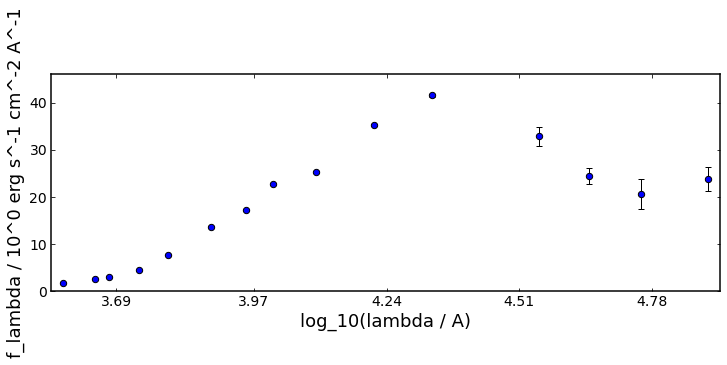

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='log_10(lambda / A)', ylabel='f_lambda / 10^0 erg s^-1 cm^-2 A^-1'>])

In [41]:
def load_data(Id):
    global df
    flux = [ 'Y', 'J', 'H', 'Ks', 'B', 'V', 'gp', 'rp', 'ip', 'zp', 'u', 'ch1', 'ch2', 'ch3', 'ch4']
    flux_err = [ 'eY', 'eJ', 'eH', 'eKs', 'eB', 'eV', 'egp', 'erp', 'eip', 'ezp', 'eu', 'ech1', 'ech2', 'ech3', 'ech4']
    photometry=np.column_stack(([df.loc[df['id'] == int(Id), flux[l]] for l in range(15)],[df.loc[df['id'] == int(Id), flux_err[l]] for l in range(15)]))
    return photometry

galaxy = pipes.galaxy(ID= '3', load_data= load_data, spectrum_exists = False, out_units='mujy', filt_list = filter_list)
galaxy.plot()

In [20]:
print(galaxy.photometry)

[[1.02032759e+04 2.27999900e+01 1.89237900e-01]
 [1.24993110e+04 2.53418200e+01 1.90730900e-01]
 [1.63816700e+04 3.52482600e+01 2.53063700e-01]
 [2.14976583e+04 4.16480100e+01 3.31073000e-01]
 [4.42713421e+03 2.58475800e+00 3.73250200e-02]
 [5.45484985e+03 4.40286000e+00 5.22550300e-02]
 [4.72838533e+03 3.12037200e+00 3.20995200e-02]
 [6.24895357e+03 7.69194100e+00 7.68895500e-02]
 [7.64588905e+03 1.37206800e+01 8.32348100e-02]
 [9.01091189e+03 1.71896700e+01 1.27651600e-01]
 [3.81332031e+03 1.82482000e+00 9.36858100e-02]
 [3.54392858e+04 3.28949200e+01 2.00360700e+00]
 [4.48408365e+04 2.44747600e+01 1.70500700e+00]
 [5.71638984e+04 2.06452200e+01 3.14911200e+00]
 [7.82833732e+04 2.38887600e+01 2.58849100e+00]]


Faccio il fit di un singolo oggetto, specificando il modello 

In [43]:
"""
burst = {}
burst["age"] = (0., 15.)                  # Vary age from 0 to 15 Gyr
burst["metallicity"] = (0., 2.5)          # Vary metallicity from 0 to 2.5 Solar
burst["metallicity_prior"] = "Gaussian"
burst["metallicity_prior_mu"] = 1.
burst["metallicity_prior_sigma"] = .5
burst["massformed"] = (0., 13.)           # Vary log_10(mass formed) from 0 to 13
"""
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = 1.                   # fix Z at Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 4.)                     # Vary Av between 0 and 4 magnitudes

fit_instructions = {}
fit_instructions["exp"] = exp         # Add the exponentially decaying sfh component to the fit
#fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
#fit_instructions["redshift_prior"] = "Gaussian"
#fit_instructions["redshift_prior_mu"] = 0.7
#fit_instructions["redshift_prior_sigma"] = 0.
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False, use_MPI=False)

/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars


Results loaded from pipes/posterior/./3.h5

Fitting not performed as results have already been loaded from pipes/posterior/./3.h5. To start over delete this file or change run.



Carico i redshift fotometrici delle galassie del catalogo

In [23]:
df_1 = pd.read_csv('COSMOS_photometry/UVISTA4.1_trimmed.zout', sep=' ', header=None, skipinitialspace= True, skiprows= 1, engine='python')
print(df_1.head(1))

   0    1      2      3         4      5         6      7    8      9      10  \
0   3 -1.0  0.549  0.547  14.05224  0.549  14.05224  0.547  1.0  0.517  0.577   

      11     12    13     14  15        16      17     18      19  
0  0.492  0.595  0.47  0.604  29  0.072602  0.5469  0.999  0.5625  


Verifico che l'ordine degli oggetti sia lo stesso in entrambi i files e salvo i redshift in un array

In [33]:
id_file1, id_file2 = df['id'], df_1[0]
print('numero di galassie', len(id_file1))
print('numero di id coincidenti', (id_file1 == id_file2).sum())
z_photo = df_1[17]
print('redshifts:\n', z_photo)

numero di galassie 140560
numero di id coincidenti 140560
redshifts:
 0         0.5469
1         0.7169
2         0.2395
3         0.2275
4         0.7245
           ...  
140555    1.4460
140556    1.9448
140557    3.3228
140558    0.6564
140559    1.4636
Name: 17, Length: 140560, dtype: float64


Faccio un fit di tutto il catalogo con lo stesso modello

In [ ]:
fit_cat = pipes.fit_catalogue(id_file1, fit_instructions, load_data, spectrum_exists= False, redshifts = z_photo, cat_filt_list = filter_list)
fit_cat.fit(verbose=False, mpi_serial=False)


Bagpipes: fitting object 4

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2623.0608037039501      +/-   2.5711650303922483E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.570      1.932      3.321
exp:age                        2.639      7.668     12.624
exp:massformed                 3.286      7.995     13.013
exp:tau                        1.811      5.462      8.610




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 2 out of 140560 objects completed.

Bagpipes: fitting object 5

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -72501.845057952829      +/-   1.7373799883459311E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.707      2.058      3.481
exp:age                        2.323      8.152     13.019
exp:massformed                 3.635      8.543     12.917
exp:tau                        1.994      5.123      8.440




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 3 out of 140560 objects completed.

Bagpipes: fitting object 11

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -713904.12238869071      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      1.953      3.352
exp:age                        2.075      7.495     12.612
exp:massformed                 2.780      7.694     12.536
exp:tau                        1.704      4.887      8.417




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 4 out of 140560 objects completed.

Bagpipes: fitting object 13

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -74261.681188180955      +/-   1.7583313149828386E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.486      1.805      3.312
exp:age                        2.535      7.742     12.328
exp:massformed                 2.875      7.650     12.469
exp:tau                        1.963      5.244      8.532




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 5 out of 140560 objects completed.

Bagpipes: fitting object 15

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -330.23260192352382      +/-   5.1687916251847266E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.679      2.090      3.490
exp:age                        2.593      7.483     12.205
exp:massformed                 3.739      8.073     12.651
exp:tau                        1.746      4.691      8.051




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 6 out of 140560 objects completed.

Bagpipes: fitting object 16

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   468.40061977716141      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.704      2.211      3.364
exp:age                        2.378      7.525     12.569
exp:massformed                 3.280      7.797     12.499
exp:tau                        1.765      5.084      8.542




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 7 out of 140560 objects completed.

Bagpipes: fitting object 18

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3866.7416439407934      +/-   3.1202789590802928E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.672      1.978      3.373
exp:age                        2.456      7.172     12.862
exp:massformed                 2.876      7.946     13.460
exp:tau                        1.514      4.951      8.338




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 8 out of 140560 objects completed.

Bagpipes: fitting object 21

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2785.3807380338981      +/-   2.6499879180977832E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.632      1.982      3.333
exp:age                        2.723      7.810     12.426
exp:massformed                 2.866      7.345     12.406
exp:tau                        1.925      5.072      8.615




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 9 out of 140560 objects completed.

Bagpipes: fitting object 22

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -17556.542638409504      +/-   1.1138409772891511E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.632      2.123      3.354
exp:age                        2.749      7.493     12.370
exp:massformed                 3.550      8.450     13.312
exp:tau                        1.705      5.116      8.422




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 10 out of 140560 objects completed.

Bagpipes: fitting object 28

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -676.83663580130894      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.723      1.880      3.358
exp:age                        2.383      7.511     12.495
exp:massformed                 2.897      7.914     12.742
exp:tau                        1.747      5.174      8.620




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 11 out of 140560 objects completed.

Bagpipes: fitting object 35

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -8324.9859346103367      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.562      1.943      3.410
exp:age                        2.375      7.430     12.424
exp:massformed                 3.422      8.006     12.807
exp:tau                        1.854      5.155      8.549




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 12 out of 140560 objects completed.

Bagpipes: fitting object 38

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -39794.774860803147      +/-   2.5356620131069399E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.693      2.029      3.380
exp:age                        2.610      7.335     12.470
exp:massformed                 3.623      8.553     13.193
exp:tau                        1.819      5.307      8.454




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 13 out of 140560 objects completed.

Bagpipes: fitting object 41

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -352422.94633524108      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.639      1.855      3.380
exp:age                        2.081      7.328     12.447
exp:massformed                 2.923      7.727     12.815
exp:tau                        2.122      5.222      8.472




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 14 out of 140560 objects completed.

Bagpipes: fitting object 42

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4928.9024716436606      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.773      2.112      3.378
exp:age                        2.651      7.623     12.412
exp:massformed                 2.894      7.238     12.347
exp:tau                        1.607      5.022      8.628




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 15 out of 140560 objects completed.

Bagpipes: fitting object 43

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -203.23536332016212      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.527      2.004      3.460
exp:age                        1.953      7.238     12.088
exp:massformed                 3.473      8.606     12.994
exp:tau                        2.064      5.131      8.458




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 16 out of 140560 objects completed.

Bagpipes: fitting object 44

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -18457.136589626803      +/-   1.1419826850141826E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.801      2.227      3.356
exp:age                        2.601      7.222     12.301
exp:massformed                 3.029      8.493     12.790
exp:tau                        1.909      4.967      8.412




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 17 out of 140560 objects completed.

Bagpipes: fitting object 46

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -233.53314253091091      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.573      1.827      3.270
exp:age                        2.092      7.252     12.372
exp:massformed                 3.784      8.524     12.743
exp:tau                        1.706      5.056      8.184




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 18 out of 140560 objects completed.

Bagpipes: fitting object 49

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -94.824823032020504      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.748      2.120      3.392
exp:age                        2.669      7.845     12.796
exp:massformed                 3.409      8.254     12.689
exp:tau                        1.884      4.947      8.332




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 19 out of 140560 objects completed.

Bagpipes: fitting object 53

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -41941.831460879963      +/-   2.6036182151372239E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.514      1.967      3.264
exp:age                        2.397      7.361     12.242
exp:massformed                 3.126      7.902     12.535
exp:tau                        1.723      5.034      8.537




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 20 out of 140560 objects completed.

Bagpipes: fitting object 54

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6774.3907911170618      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.702      2.025      3.361
exp:age                        1.978      7.493     12.732
exp:massformed                 2.896      7.685     12.406
exp:tau                        1.789      5.182      8.582




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 21 out of 140560 objects completed.

Bagpipes: fitting object 55

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2392.5906279264464      +/-   2.4567527784945304E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.613      1.934      3.218
exp:age                        2.709      8.120     12.637
exp:massformed                 3.178      8.155     12.760
exp:tau                        1.791      5.224      8.505




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 22 out of 140560 objects completed.

Bagpipes: fitting object 56

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6030.1053515727917      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.562      1.993      3.325
exp:age                        2.762      7.716     13.032
exp:massformed                 3.526      7.527     12.483
exp:tau                        2.168      5.327      8.280




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 23 out of 140560 objects completed.

Bagpipes: fitting object 58

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -12386.583960795733      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.561      2.029      3.396
exp:age                        2.209      7.209     12.319
exp:massformed                 3.530      8.275     12.426
exp:tau                        1.939      5.308      8.516




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 24 out of 140560 objects completed.

Bagpipes: fitting object 60

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6990.9417310926428      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.559      1.961      3.360
exp:age                        2.406      6.973     12.768
exp:massformed                 3.016      7.750     12.977
exp:tau                        1.557      4.777      8.447




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 25 out of 140560 objects completed.

Bagpipes: fitting object 61

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4031.1963273097786      +/-   3.1857218967462717E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.756      1.916      3.354
exp:age                        2.366      7.850     12.781
exp:massformed                 3.398      8.396     12.911
exp:tau                        1.918      5.323      8.657




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 26 out of 140560 objects completed.

Bagpipes: fitting object 62

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -81.529389660601282      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.721      2.025      3.349
exp:age                        2.569      7.493     12.426
exp:massformed                 3.195      7.918     13.031
exp:tau                        1.796      4.919      8.169




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 27 out of 140560 objects completed.

Bagpipes: fitting object 63

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1878.7746395017207      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.683      2.174      3.326
exp:age                        2.580      7.263     12.437
exp:massformed                 3.219      7.742     12.526
exp:tau                        2.187      5.122      8.159




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 28 out of 140560 objects completed.

Bagpipes: fitting object 67

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2823.0073506883955      +/-   2.6679454472965485E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.537      2.026      3.311
exp:age                        2.100      6.884     12.408
exp:massformed                 2.964      7.893     12.833
exp:tau                        1.837      4.985      8.280




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 29 out of 140560 objects completed.

Bagpipes: fitting object 70

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -718.67103235289608      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.686      1.962      3.442
exp:age                        2.218      7.431     12.776
exp:massformed                 2.957      7.652     12.140
exp:tau                        2.186      5.552      8.288




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 30 out of 140560 objects completed.

Bagpipes: fitting object 71

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1661.4584461167995      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.588      1.959      3.400
exp:age                        2.365      7.562     12.517
exp:massformed                 2.985      8.395     13.395
exp:tau                        1.821      5.258      8.651




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 31 out of 140560 objects completed.

Bagpipes: fitting object 72

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1823.6672031473533      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.487      1.929      3.414
exp:age                        2.483      7.323     12.699
exp:massformed                 3.229      7.431     12.537
exp:tau                        2.025      5.132      8.256




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 32 out of 140560 objects completed.

Bagpipes: fitting object 73

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -19189.790463360398      +/-   1.1645765321711538E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.485      1.796      3.168
exp:age                        2.262      7.242     12.440
exp:massformed                 2.597      8.152     12.720
exp:tau                        2.066      5.636      8.258




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 33 out of 140560 objects completed.

Bagpipes: fitting object 75

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   506.02847758323043      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.709      2.072      3.396
exp:age                        2.629      7.912     12.657
exp:massformed                 3.231      7.912     12.719
exp:tau                        1.663      4.880      8.130




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 34 out of 140560 objects completed.

Bagpipes: fitting object 76

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1071.5406162838647      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.676      1.983      3.238
exp:age                        2.269      7.828     13.075
exp:massformed                 3.052      7.769     12.246
exp:tau                        1.697      5.037      8.262




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 35 out of 140560 objects completed.

Bagpipes: fitting object 77

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -31706.825307209027      +/-   1.4971471846546623E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      1.963      3.303
exp:age                        2.298      7.461     12.329
exp:massformed                 2.714      7.409     12.415
exp:tau                        1.991      5.033      8.624




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 36 out of 140560 objects completed.

Bagpipes: fitting object 80

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -838.73305716958009      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.606      2.037      3.394
exp:age                        2.533      7.477     12.496
exp:massformed                 3.531      7.837     12.442
exp:tau                        1.943      5.289      8.601




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 37 out of 140560 objects completed.

Bagpipes: fitting object 81

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -12349.570141831795      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.642      1.865      3.140
exp:age                        2.627      8.216     13.333
exp:massformed                 3.252      7.665     12.523
exp:tau                        1.793      4.811      8.199




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 38 out of 140560 objects completed.

Bagpipes: fitting object 84

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -217785.47627304241      +/-   1.8764763008351579E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.646      2.013      3.405
exp:age                        2.144      7.658     12.578
exp:massformed                 3.371      8.448     12.653
exp:tau                        2.049      5.492      8.628




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 39 out of 140560 objects completed.

Bagpipes: fitting object 85

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4992.5064092518487      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.717      2.143      3.336
exp:age                        2.089      7.842     12.959
exp:massformed                 3.312      7.710     12.614
exp:tau                        1.736      5.159      8.376




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 40 out of 140560 objects completed.

Bagpipes: fitting object 93

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4367.4540793448068      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.733      1.966      3.391
exp:age                        2.004      7.483     12.593
exp:massformed                 3.394      7.475     12.733
exp:tau                        1.774      4.725      8.117




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 41 out of 140560 objects completed.

Bagpipes: fitting object 94

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2305.8150878059078      +/-   2.4088537102346590E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.680      2.012      3.299
exp:age                        2.308      7.435     12.530
exp:massformed                 3.777      8.005     13.218
exp:tau                        1.702      5.314      8.489




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 42 out of 140560 objects completed.

Bagpipes: fitting object 97

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -8793.2915684066247      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.699      2.215      3.510
exp:age                        2.635      7.801     12.134
exp:massformed                 3.389      8.448     12.791
exp:tau                        1.911      5.037      8.535




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 43 out of 140560 objects completed.

Bagpipes: fitting object 98

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -229.28347919959501      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.527      1.845      3.425
exp:age                        2.303      7.678     12.452
exp:massformed                 3.722      8.800     13.412
exp:tau                        2.068      5.466      8.631




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 44 out of 140560 objects completed.

Bagpipes: fitting object 99

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1595.2267589624557      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.530      1.741      3.256
exp:age                        2.495      8.150     12.859
exp:massformed                 3.155      7.774     13.146
exp:tau                        1.613      5.409      8.561




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 45 out of 140560 objects completed.

Bagpipes: fitting object 100

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   470.06865362895985      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.607      2.047      3.352
exp:age                        2.456      7.792     12.419
exp:massformed                 3.148      7.701     12.731
exp:tau                        1.876      4.997      8.298




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 46 out of 140560 objects completed.

Bagpipes: fitting object 101

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   381.54791485452211      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.761      2.042      3.288
exp:age                        2.553      7.237     12.333
exp:massformed                 3.182      8.182     12.486
exp:tau                        1.848      5.076      8.462




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 47 out of 140560 objects completed.

Bagpipes: fitting object 102

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1208.3477499062099      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.637      2.107      3.477
exp:age                        2.271      7.829     12.669
exp:massformed                 2.938      8.253     12.742
exp:tau                        1.503      4.736      8.137




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 48 out of 140560 objects completed.

Bagpipes: fitting object 104

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   212.92309605308324      +/-   3.1573587985394069E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.578      1.967      3.287
exp:age                        2.896      7.537     12.589
exp:massformed                 3.398      8.056     12.927
exp:tau                        1.943      5.297      8.382




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 49 out of 140560 objects completed.

Bagpipes: fitting object 105

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3442.4827296390022      +/-   2.9436730068303396E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.733      2.065      3.323
exp:age                        2.761      7.122     13.077
exp:massformed                 3.141      7.597     12.543
exp:tau                        1.873      4.961      8.221




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 50 out of 140560 objects completed.

Bagpipes: fitting object 106

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1475.6642718797091      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.529      1.921      3.348
exp:age                        2.248      7.438     12.223
exp:massformed                 3.536      8.488     13.072
exp:tau                        1.687      5.105      8.365




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 51 out of 140560 objects completed.

Bagpipes: fitting object 107

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1524.1820732499334      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.666      1.967      3.385
exp:age                        3.049      7.943     12.822
exp:massformed                 3.270      7.614     12.338
exp:tau                        1.856      5.089      8.311




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 52 out of 140560 objects completed.

Bagpipes: fitting object 108

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -16104.222850116666      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.655      1.993      3.418
exp:age                        2.120      6.618     12.175
exp:massformed                 3.627      7.615     12.483
exp:tau                        1.839      4.862      8.366




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 53 out of 140560 objects completed.

Bagpipes: fitting object 111

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   488.44560626875489      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.723      2.025      3.385
exp:age                        2.554      8.420     13.053
exp:massformed                 3.233      8.675     13.067
exp:tau                        1.750      5.145      8.586




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 54 out of 140560 objects completed.

Bagpipes: fitting object 112

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2935.7860077972718      +/-   2.7200623887923548E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.512      2.056      3.490
exp:age                        2.213      7.528     13.010
exp:massformed                 3.442      8.628     13.007
exp:tau                        1.520      5.558      8.637




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 55 out of 140560 objects completed.

Bagpipes: fitting object 113

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -15835.378920730285      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.577      1.956      3.374
exp:age                        2.720      7.678     12.698
exp:massformed                 2.849      7.570     12.804
exp:tau                        2.054      5.073      8.411




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 56 out of 140560 objects completed.

Bagpipes: fitting object 114

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -10223.390216453254      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.626      1.979      3.398
exp:age                        2.564      7.687     12.131
exp:massformed                 2.814      7.486     12.341
exp:tau                        1.684      5.132      8.330




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 57 out of 140560 objects completed.

Bagpipes: fitting object 115

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3936.5707631017094      +/-   3.1500138406589020E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.713      1.965      3.411
exp:age                        2.727      7.563     12.645
exp:massformed                 3.395      7.950     12.688
exp:tau                        1.686      4.887      8.298




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 58 out of 140560 objects completed.

Bagpipes: fitting object 117

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -504.74381670893786      +/-   6.4052117500351370E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.595      2.094      3.381
exp:age                        2.540      7.447     12.419
exp:massformed                 2.964      7.393     12.369
exp:tau                        1.905      5.311      8.486




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 59 out of 140560 objects completed.

Bagpipes: fitting object 118

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -649.97678699701191      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.642      1.973      3.297
exp:age                        2.292      7.597     12.542
exp:massformed                 3.268      7.945     12.859
exp:tau                        1.914      4.908      8.412




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 60 out of 140560 objects completed.

Bagpipes: fitting object 120

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1262.4670168734099      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.659      2.037      3.319
exp:age                        2.482      7.477     12.429
exp:massformed                 3.492      8.265     12.629
exp:tau                        1.834      5.167      8.484




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 61 out of 140560 objects completed.

Bagpipes: fitting object 121

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   559.96953051293724      +/-   4.2214229606689867E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.701      2.050      3.433
exp:age                        2.232      7.697     12.827
exp:massformed                 3.275      8.061     12.750
exp:tau                        2.045      5.103      8.297




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 62 out of 140560 objects completed.

Bagpipes: fitting object 123

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   91.412932676188802      +/-   2.1490760299348769E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.636      2.019      3.289
exp:age                        2.373      7.157     12.756
exp:massformed                 3.259      7.988     12.588
exp:tau                        1.791      4.915      8.436




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 63 out of 140560 objects completed.

Bagpipes: fitting object 125

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2436.4818116369679      +/-   2.4772596755715443E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.722      2.150      3.423
exp:age                        2.395      7.846     12.803
exp:massformed                 3.415      8.503     13.222
exp:tau                        1.716      5.041      8.400




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 64 out of 140560 objects completed.

Bagpipes: fitting object 127

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   563.14094240012992      +/-   4.2749455158808488E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.798      2.036      3.336
exp:age                        2.280      7.508     12.420
exp:massformed                 3.231      8.404     12.864
exp:tau                        1.923      5.088      8.453




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 65 out of 140560 objects completed.

Bagpipes: fitting object 128

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -13050.740958097625      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.543      1.869      3.251
exp:age                        2.576      7.986     12.693
exp:massformed                 2.853      7.827     12.771
exp:tau                        1.933      5.366      8.556




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 66 out of 140560 objects completed.

Bagpipes: fitting object 134

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   631.40830577995894      +/-   4.5173872283688583E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.614      2.127      3.357
exp:age                        2.224      7.210     12.881
exp:massformed                 3.130      8.153     12.716
exp:tau                        1.773      5.544      8.772




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 67 out of 140560 objects completed.

Bagpipes: fitting object 136

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -12997.965845415352      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.656      2.016      3.407
exp:age                        2.727      7.090     12.622
exp:massformed                 3.040      8.352     12.668
exp:tau                        2.157      5.312      8.231




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 68 out of 140560 objects completed.

Bagpipes: fitting object 137

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -34198.202759306681      +/-   2.3509957893655276E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.791      2.058      3.371
exp:age                        2.168      7.275     12.662
exp:massformed                 3.035      7.812     12.806
exp:tau                        1.733      5.239      8.331




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 69 out of 140560 objects completed.

Bagpipes: fitting object 138

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -61551.148483969009      +/-   3.1542264410841553E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.724      2.092      3.356
exp:age                        2.903      8.174     12.585
exp:massformed                 2.869      7.644     12.235
exp:tau                        2.016      5.258      8.444




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 70 out of 140560 objects completed.

Bagpipes: fitting object 139

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4301.1879080464214      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.764      2.046      3.403
exp:age                        2.261      7.435     12.910
exp:massformed                 3.177      8.068     12.753
exp:tau                        2.432      5.596      8.725




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 71 out of 140560 objects completed.

Bagpipes: fitting object 140

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -17220.028921787973      +/-   1.1033809894108390E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.594      1.931      3.381
exp:age                        2.165      7.114     12.465
exp:massformed                 3.373      8.026     12.853
exp:tau                        1.961      5.064      8.606




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 72 out of 140560 objects completed.

Bagpipes: fitting object 144

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   345.11717882993867      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.682      1.983      3.418
exp:age                        2.749      7.636     12.428
exp:massformed                 3.202      8.651     13.179
exp:tau                        1.988      4.947      8.401




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 73 out of 140560 objects completed.

Bagpipes: fitting object 146

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1045.2806345488896      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.622      1.974      3.186
exp:age                        2.219      7.040     12.686
exp:massformed                 2.882      8.246     12.926
exp:tau                        1.838      5.292      8.333




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 74 out of 140560 objects completed.

Bagpipes: fitting object 147

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -736.86422280019883      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.624      2.049      3.351
exp:age                        2.230      7.930     12.924
exp:massformed                 3.133      7.938     12.422
exp:tau                        2.144      5.450      8.733




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 75 out of 140560 objects completed.

Bagpipes: fitting object 148

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -317.96111461533860      +/-   5.0702501101819847E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.626      1.950      3.256
exp:age                        2.683      7.067     12.262
exp:massformed                 3.247      7.897     12.251
exp:tau                        1.853      4.696      8.379




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 76 out of 140560 objects completed.

Bagpipes: fitting object 150

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1018.9526300243265      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.644      1.938      3.394
exp:age                        2.414      7.849     12.720
exp:massformed                 3.715      8.159     12.974
exp:tau                        1.615      5.028      8.468




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 77 out of 140560 objects completed.

Bagpipes: fitting object 153

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1699.5905058949454      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.748      2.093      3.483
exp:age                        2.400      7.102     12.371
exp:massformed                 3.387      7.667     13.034
exp:tau                        1.773      4.871      8.486




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 78 out of 140560 objects completed.

Bagpipes: fitting object 157

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -9212.7319792976868      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.663      1.946      3.395
exp:age                        2.612      7.591     12.693
exp:massformed                 3.667      8.127     12.805
exp:tau                        1.749      4.918      8.362




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 79 out of 140560 objects completed.

Bagpipes: fitting object 158

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -467.22440095336151      +/-   6.1574800348973079E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.657      2.082      3.535
exp:age                        2.882      8.020     12.480
exp:massformed                 4.101      8.141     12.973
exp:tau                        2.109      5.180      8.461




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 80 out of 140560 objects completed.

Bagpipes: fitting object 160

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -16950.051225269552      +/-   1.0943594579911082E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.775      2.016      3.384
exp:age                        2.527      7.585     12.581
exp:massformed                 2.829      7.875     12.475
exp:tau                        1.580      5.181      8.198




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 81 out of 140560 objects completed.

Bagpipes: fitting object 163

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -359.00798280584991      +/-   5.3934793595617388E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.677      1.992      3.357
exp:age                        2.725      7.849     12.921
exp:massformed                 3.266      7.854     12.160
exp:tau                        1.770      4.919      8.233




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 82 out of 140560 objects completed.

Bagpipes: fitting object 166

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   162.77713415118538      +/-   2.7676073947534322E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.621      2.056      3.345
exp:age                        2.750      7.397     12.316
exp:massformed                 3.431      8.322     13.001
exp:tau                        1.575      4.822      8.467




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 83 out of 140560 objects completed.

Bagpipes: fitting object 170

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   48.785906637300414      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.566      2.115      3.401
exp:age                        2.492      7.418     12.796
exp:massformed                 3.343      8.412     12.463
exp:tau                        1.846      5.119      8.340




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 84 out of 140560 objects completed.

Bagpipes: fitting object 171

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   364.95837592004602      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.608      2.052      3.324
exp:age                        2.485      7.247     12.676
exp:massformed                 3.285      7.713     12.734
exp:tau                        1.688      5.036      8.531




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 85 out of 140560 objects completed.

Bagpipes: fitting object 175

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -25063.659469013233      +/-   1.3309139270339592E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.653      2.067      3.399
exp:age                        2.209      7.780     12.774
exp:massformed                 3.388      8.149     13.032
exp:tau                        2.028      5.043      8.538




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 86 out of 140560 objects completed.

Bagpipes: fitting object 176

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -203.51465111458148      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.693      1.964      3.293
exp:age                        2.568      7.519     12.648
exp:massformed                 2.992      7.659     12.820
exp:tau                        1.834      4.981      8.719




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 87 out of 140560 objects completed.

Bagpipes: fitting object 177

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3328.5845657772961      +/-   2.8951909341552503E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.542      1.952      3.253
exp:age                        2.609      7.620     12.710
exp:massformed                 3.484      8.442     12.365
exp:tau                        1.913      5.173      8.629




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 88 out of 140560 objects completed.

Bagpipes: fitting object 178

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -5079.0601823671095      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.548      1.879      3.331
exp:age                        2.162      7.039     12.379
exp:massformed                 3.097      7.783     12.232
exp:tau                        1.628      4.522      8.501




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 89 out of 140560 objects completed.

Bagpipes: fitting object 179

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -404.42660512795362      +/-   5.7294916347016892E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.708      2.101      3.448
exp:age                        2.389      7.310     12.236
exp:massformed                 3.332      8.183     12.881
exp:tau                        1.825      5.296      8.387




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 90 out of 140560 objects completed.

Bagpipes: fitting object 183

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4232.2920596768272      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.667      1.969      3.287
exp:age                        2.418      7.744     13.076
exp:massformed                 3.874      8.338     12.930
exp:tau                        2.349      5.556      8.609




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 91 out of 140560 objects completed.

Bagpipes: fitting object 184

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -419730.01453069114      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.583      2.093      3.355
exp:age                        2.082      7.336     12.503
exp:massformed                 3.641      8.071     12.445
exp:tau                        1.823      4.823      7.953




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 92 out of 140560 objects completed.

Bagpipes: fitting object 185

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -326.81632008846941      +/-   5.1522690737186212E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.637      2.257      3.490
exp:age                        2.197      7.337     12.238
exp:massformed                 3.860      8.001     12.580
exp:tau                        2.036      5.082      8.488




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 93 out of 140560 objects completed.

Bagpipes: fitting object 188

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -13498.360879756578      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.715      2.021      3.206
exp:age                        2.501      7.458     12.461
exp:massformed                 2.988      8.362     12.760
exp:tau                        1.829      5.270      8.496




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 94 out of 140560 objects completed.

Bagpipes: fitting object 189

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -28552.823839161363      +/-   1.4203985697482544E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.614      1.918      3.476
exp:age                        2.373      7.848     12.528
exp:massformed                 3.417      7.994     12.910
exp:tau                        1.851      5.126      8.414




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 95 out of 140560 objects completed.

Bagpipes: fitting object 192

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -7079.8608343090782      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.455      2.067      3.331
exp:age                        2.444      7.387     12.189
exp:massformed                 3.319      7.556     12.799
exp:tau                        1.768      5.239      8.621




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 96 out of 140560 objects completed.

Bagpipes: fitting object 193

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2198.8659415647999      +/-   2.3546777010205058E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.525      1.888      3.339
exp:age                        2.307      7.230     12.054
exp:massformed                 3.425      8.482     12.930
exp:tau                        1.810      4.989      8.373




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 97 out of 140560 objects completed.

Bagpipes: fitting object 194

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -20693.967697007898      +/-   1.2095884121229460E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.624      2.031      3.377
exp:age                        2.812      7.817     12.544
exp:massformed                 3.504      7.893     12.457
exp:tau                        2.082      5.469      8.418




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 98 out of 140560 objects completed.

Bagpipes: fitting object 196

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2204.3915735757182      +/-   2.3546777010205058E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.538      1.809      3.324
exp:age                        2.135      7.217     12.606
exp:massformed                 3.200      7.622     12.636
exp:tau                        1.812      4.912      8.393




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 99 out of 140560 objects completed.

Bagpipes: fitting object 203

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -85899.319970021606      +/-   1.8911099588383203E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.610      1.909      3.220
exp:age                        2.480      7.078     12.268
exp:massformed                 3.425      7.721     12.615
exp:tau                        1.718      5.100      8.370




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 100 out of 140560 objects completed.

Bagpipes: fitting object 205

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   292.66230098738924      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.667      2.081      3.433
exp:age                        2.740      7.831     12.698
exp:massformed                 3.205      7.643     12.112
exp:tau                        2.302      5.057      8.527




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 101 out of 140560 objects completed.

Bagpipes: fitting object 206

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -29731.299047263976      +/-   1.4493967235215862E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.715      2.103      3.420
exp:age                        2.446      7.422     12.718
exp:massformed                 3.005      7.817     12.353
exp:tau                        1.488      4.449      8.327




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 102 out of 140560 objects completed.

Bagpipes: fitting object 207

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3031.2915369459097      +/-   2.7631880177403298E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.569      1.944      3.330
exp:age                        3.500      7.363     12.730
exp:massformed                 3.316      8.045     13.101
exp:tau                        1.797      4.805      8.536




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 103 out of 140560 objects completed.

Bagpipes: fitting object 209

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   243.18822941898006      +/-   3.3759599348321665E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.816      2.089      3.335
exp:age                        2.547      7.776     12.626
exp:massformed                 3.668      8.076     13.170
exp:tau                        1.963      5.383      8.579




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 104 out of 140560 objects completed.

Bagpipes: fitting object 212

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1603.6404444464381      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.630      1.965      3.373
exp:age                        2.381      7.660     12.144
exp:massformed                 2.887      7.917     13.024
exp:tau                        1.758      5.000      8.429




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 105 out of 140560 objects completed.

Bagpipes: fitting object 215

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1853.5519482057578      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.587      1.803      3.239
exp:age                        2.396      7.289     12.143
exp:massformed                 2.789      7.712     12.802
exp:tau                        2.176      5.397      8.627




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 106 out of 140560 objects completed.

Bagpipes: fitting object 216

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   448.88987587332559      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.657      1.992      3.272
exp:age                        2.496      7.724     12.858
exp:massformed                 3.488      7.633     12.950
exp:tau                        1.608      4.928      8.217




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 107 out of 140560 objects completed.

Bagpipes: fitting object 217

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -11752.794727285431      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.628      2.127      3.463
exp:age                        2.451      6.905     12.235
exp:massformed                 2.967      8.069     12.548
exp:tau                        2.071      5.190      8.338




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 108 out of 140560 objects completed.

Bagpipes: fitting object 218

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3946.1206558360868      +/-   3.1516375127443816E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.735      2.116      3.297
exp:age                        2.523      7.752     12.366
exp:massformed                 3.372      8.472     13.176
exp:tau                        1.820      5.248      8.191




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 109 out of 140560 objects completed.

Bagpipes: fitting object 219

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   398.77068449513973      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.752      2.109      3.465
exp:age                        2.006      7.637     12.774
exp:massformed                 3.011      7.551     12.900
exp:tau                        1.867      4.869      8.149




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 110 out of 140560 objects completed.

Bagpipes: fitting object 221

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -249.28126630083190      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.622      2.026      3.265
exp:age                        2.796      8.188     12.868
exp:massformed                 3.033      7.664     12.685
exp:tau                        2.102      5.337      8.473




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 111 out of 140560 objects completed.

Bagpipes: fitting object 223

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   510.09612155470148      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.627      1.996      3.353
exp:age                        2.601      7.985     12.630
exp:massformed                 3.045      7.850     12.185
exp:tau                        1.821      5.236      8.710




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 112 out of 140560 objects completed.

Bagpipes: fitting object 224

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -32638.451281919261      +/-   1.5186496188244975E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.734      2.046      3.368
exp:age                        2.552      7.395     12.760
exp:massformed                 3.169      8.323     12.702
exp:tau                        1.703      4.833      8.406




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 113 out of 140560 objects completed.

Bagpipes: fitting object 225

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6189.4679639481610      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.671      2.172      3.394
exp:age                        2.799      7.327     12.779
exp:massformed                 3.022      7.677     12.479
exp:tau                        1.926      4.797      8.161




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 114 out of 140560 objects completed.

Bagpipes: fitting object 228

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -97.880119953087046      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.628      1.875      3.206
exp:age                        2.760      7.212     12.610
exp:massformed                 3.226      7.898     12.588
exp:tau                        2.300      5.195      8.338




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 115 out of 140560 objects completed.

Bagpipes: fitting object 230

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -523.14368289147876      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.671      2.064      3.393
exp:age                        2.364      7.321     12.394
exp:massformed                 3.431      7.669     12.531
exp:tau                        1.939      5.202      8.494




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 116 out of 140560 objects completed.

Bagpipes: fitting object 231

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   95.660506472709130      +/-   2.6656007498500224E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.578      1.893      3.338
exp:age                        2.928      7.690     12.967
exp:massformed                 3.792      8.323     12.780
exp:tau                        1.841      4.890      8.368




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 117 out of 140560 objects completed.

Bagpipes: fitting object 232

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -63.465543664889054      +/-   6.3918860523483805E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.629      2.035      3.404
exp:age                        2.991      8.061     12.741
exp:massformed                 3.172      7.193     12.395
exp:tau                        1.888      5.092      8.207




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 118 out of 140560 objects completed.

Bagpipes: fitting object 234

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -431.96572207765064      +/-   5.9245937537141691E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.600      2.001      3.307
exp:age                        2.313      6.910     12.483
exp:massformed                 3.252      7.069     12.283
exp:tau                        2.180      5.235      8.653




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 119 out of 140560 objects completed.

Bagpipes: fitting object 237

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   121.71136764438415      +/-   2.5981062314156731E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.793      2.109      3.409
exp:age                        2.710      7.351     12.392
exp:massformed                 2.975      7.909     12.854
exp:tau                        2.120      4.890      8.268




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 120 out of 140560 objects completed.

Bagpipes: fitting object 241

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -53.580345874573695      +/-   4.1295309247228558E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.596      2.133      3.390
exp:age                        3.032      8.149     12.720
exp:massformed                 3.520      8.688     12.963
exp:tau                        2.020      5.023      8.609




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 121 out of 140560 objects completed.

Bagpipes: fitting object 242

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4272.3043113953054      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.567      1.960      3.418
exp:age                        2.654      7.583     12.660
exp:massformed                 3.264      8.238     12.594
exp:tau                        2.175      5.313      8.693




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 122 out of 140560 objects completed.

Bagpipes: fitting object 243

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -52.283345845833750      +/-   4.3800289799866286E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.758      2.126      3.398
exp:age                        2.818      7.553     12.877
exp:massformed                 3.653      8.544     12.942
exp:tau                        1.897      5.070      8.247




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 123 out of 140560 objects completed.

Bagpipes: fitting object 246

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   467.74430888776487      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.555      1.754      3.324
exp:age                        2.442      6.449     12.582
exp:massformed                 3.142      7.451     12.497
exp:tau                        2.190      5.254      8.356




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 124 out of 140560 objects completed.

Bagpipes: fitting object 247

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -226.87527431878877      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.548      2.100      3.363
exp:age                        2.678      7.377     12.654
exp:massformed                 3.397      7.447     12.387
exp:tau                        1.808      5.293      8.328




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 125 out of 140560 objects completed.

Bagpipes: fitting object 248

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6353.8446479744898      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.709      1.857      3.314
exp:age                        2.525      7.536     12.129
exp:massformed                 3.324      7.943     12.899
exp:tau                        2.175      5.101      8.333




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 126 out of 140560 objects completed.

Bagpipes: fitting object 249

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -994.91332376907599      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.745      2.008      3.293
exp:age                        2.505      7.937     12.693
exp:massformed                 3.194      8.061     12.705
exp:tau                        1.786      4.943      8.668




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 127 out of 140560 objects completed.

Bagpipes: fitting object 250

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4376.0999206100014      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.628      1.926      3.411
exp:age                        2.306      7.654     12.671
exp:massformed                 3.183      7.616     12.406
exp:tau                        1.887      5.086      8.217




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 128 out of 140560 objects completed.

Bagpipes: fitting object 251

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -38.866520724218489      +/-   3.5262583393452262E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 4.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.579      1.910      3.283
exp:age                        2.522      7.797     12.716
exp:massformed                 3.400      7.788     13.063
exp:tau                        1.651      5.138      8.370




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 129 out of 140560 objects completed.

Bagpipes: fitting object 252

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3994.0269818798452      +/-   3.1701603200139356E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.680      1.900      3.252
exp:age                        2.487      7.771     12.496
exp:massformed                 3.565      7.953     12.970
exp:tau                        2.005      5.248      8.043




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 130 out of 140560 objects completed.

Bagpipes: fitting object 253

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -5762.8760406908104      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.771      2.117      3.422
exp:age                        2.492      8.346     13.045
exp:massformed                 2.699      7.560     12.502
exp:tau                        2.116      5.905      8.724




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 131 out of 140560 objects completed.

Bagpipes: fitting object 254

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -696.42842625118305      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.698      1.914      3.312
exp:age                        2.337      7.449     12.550
exp:massformed                 3.824      8.181     12.611
exp:tau                        2.082      5.156      8.231




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 132 out of 140560 objects completed.

Bagpipes: fitting object 256

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -274.09864932222877      +/-   4.7159291374331671E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.665      1.894      3.286
exp:age                        2.275      7.117     12.262
exp:massformed                 2.948      8.019     12.430
exp:tau                        1.975      5.068      8.636




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 133 out of 140560 objects completed.

Bagpipes: fitting object 260

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1588.3884272911275      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.496      1.859      3.196
exp:age                        2.624      7.641     12.524
exp:massformed                 3.137      8.139     12.659
exp:tau                        1.892      4.886      8.221




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 134 out of 140560 objects completed.

Bagpipes: fitting object 261

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   518.31601750807113      +/-   4.1329707678221980E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 5.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.628      2.050      3.367
exp:age                        2.798      6.829     12.640
exp:massformed                 2.901      7.635     13.061
exp:tau                        1.657      5.007      8.342




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 135 out of 140560 objects completed.

Bagpipes: fitting object 262

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -286.21093301218400      +/-   4.8113908936048903E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 7.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.653      2.096      3.377
exp:age                        2.152      6.748     12.307
exp:massformed                 3.385      8.558     12.865
exp:tau                        2.017      5.216      8.756




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 136 out of 140560 objects completed.

Bagpipes: fitting object 263

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -52266.206303544575      +/-   2.9063136778925875E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 5.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.700      2.144      3.335
exp:age                        2.530      7.600     12.800
exp:massformed                 3.336      7.874     13.044
exp:tau                        2.274      5.456      8.706




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 137 out of 140560 objects completed.

Bagpipes: fitting object 265

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   214.81519046545773      +/-   3.1809005890193779E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 6.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.730      2.039      3.421
exp:age                        2.400      7.788     12.699
exp:massformed                 3.472      7.934     12.637
exp:tau                        1.950      5.203      8.426




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 138 out of 140560 objects completed.

Bagpipes: fitting object 267

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -13369.444733803522      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 4.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.629      2.065      3.301
exp:age                        2.775      6.791     12.800
exp:massformed                 3.044      7.921     12.859
exp:tau                        1.834      4.972      8.509




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 139 out of 140560 objects completed.

Bagpipes: fitting object 268

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1072.9143230094119      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.632      2.021      3.288
exp:age                        2.639      6.986     12.204
exp:massformed                 3.049      7.645     12.635
exp:tau                        1.768      5.341      8.562




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 140 out of 140560 objects completed.

Bagpipes: fitting object 271

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -812.35615953275112      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.516      1.991      3.316
exp:age                        2.536      7.734     12.125
exp:massformed                 3.247      7.810     12.357
exp:tau                        1.677      5.024      8.484




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 141 out of 140560 objects completed.

Bagpipes: fitting object 272

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   505.79912601149908      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 4.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.643      1.974      3.374
exp:age                        2.640      7.218     12.336
exp:massformed                 3.376      7.930     12.733
exp:tau                        2.160      5.360      8.400




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 142 out of 140560 objects completed.

Bagpipes: fitting object 277

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -10102.900921830751      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.541      1.873      3.333
exp:age                        2.894      7.907     12.899
exp:massformed                 3.011      7.801     12.920
exp:tau                        1.400      5.158      8.169




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 143 out of 140560 objects completed.

Bagpipes: fitting object 278

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4422.1598197729390      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.671      1.991      3.316
exp:age                        2.079      7.738     12.480
exp:massformed                 2.949      8.084     12.705
exp:tau                        1.887      5.235      8.520




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 144 out of 140560 objects completed.

Bagpipes: fitting object 284

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -5078.7203981618550      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.710      1.898      3.337
exp:age                        2.591      7.847     12.828
exp:massformed                 2.962      7.465     12.374
exp:tau                        1.592      4.637      8.224




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 145 out of 140560 objects completed.

Bagpipes: fitting object 288

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -617.49091994094420      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.563      1.945      3.204
exp:age                        2.524      7.886     12.961
exp:massformed                 3.752      8.314     12.805
exp:tau                        2.012      5.292      8.636




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 146 out of 140560 objects completed.

Bagpipes: fitting object 290

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1293.2939943078222      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.589      1.993      3.412
exp:age                        2.389      7.127     13.204
exp:massformed                 3.253      7.473     12.065
exp:tau                        2.119      5.588      8.420




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 147 out of 140560 objects completed.

Bagpipes: fitting object 291

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -828.00022089984509      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.694      1.886      3.339
exp:age                        2.662      7.436     13.015
exp:massformed                 3.262      8.558     13.247
exp:tau                        1.742      4.511      8.168




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 148 out of 140560 objects completed.

Bagpipes: fitting object 292

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3306.3068947461938      +/-   2.8851603522121132E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.610      2.039      3.401
exp:age                        2.564      7.888     12.906
exp:massformed                 3.014      7.681     12.544
exp:tau                        1.754      4.973      8.569




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 149 out of 140560 objects completed.

Bagpipes: fitting object 293

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4516.7822236790116      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.572      1.936      3.354
exp:age                        2.457      6.985     12.494
exp:massformed                 2.952      8.162     12.571
exp:tau                        1.930      5.222      8.363




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 150 out of 140560 objects completed.

Bagpipes: fitting object 294

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1756.1430568157807      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.676      2.073      3.309
exp:age                        2.657      7.111     12.187
exp:massformed                 3.143      8.279     12.496
exp:tau                        1.608      5.266      8.554




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 151 out of 140560 objects completed.

Bagpipes: fitting object 296

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************


ERROR: Interrupt received: Terminating
Exception ignored on calling ctypes callback function: <function run.<locals>.loglike at 0x7fa5dc9259d0>
Traceback (most recent call last):
  File "/home/michela/.local/lib/python3.8/site-packages/pymultinest/run.py", line 221, in loglike
    return LogLikelihood(cube, ndim, nparams)
  File "/home/michela/.local/lib/python3.8/site-packages/bagpipes/fitting/fitted_model.py", line 141, in lnlike
    self.model_galaxy.update(self.model_components)
  File "/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/model_galaxy.py", line 231, in update
    self._calculate_full_spectrum(model_components)
  File "/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/model_galaxy.py", line 322, in _calculate_full_spectrum
    ldist_cm = 3.086*10**24*np.interp(model_comp["redshift"],
  File "<__array_function__ internals>", line 5, in interp
  File "/home/michela/.local/lib/python3.8/site-packages/numpy/lib/function_base.py", line 1397, in